In [99]:
import os
import tarfile
from pycocotools.coco import COCO
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import random
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from tqdm import tqdm
import json
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import re

In [100]:
#file path in google drive
drive.mount('/content/drive')
dataset_root = "/content/drive/MyDrive"
#Paste data from Drive to Colab to be faster while training
#!cp -r /content/drive/MyDrive/nycu-hw2-data /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
#extract dataset
extract_path = os.path.join(dataset_root, "nycu-hw2-data")

if not os.path.exists(extract_path):
    dataset_path = os.path.join(dataset_root, "nycu-hw2-data.tar.gz")
    os.makedirs(extract_path, exist_ok=True)
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=dataset_root)  # On extrait directement dans dataset_root
    print("Extraction terminée.")
else:
    print("Le dataset a déjà été extrait.")


Le dataset a déjà été extrait.


In [102]:
# === Check data path ===

dataset_path = "/content/drive/MyDrive/nycu-hw2-data"
# Chemins vers les dossiers d’images
train_img_dir = os.path.join(dataset_path, "train")
valid_img_dir = os.path.join(dataset_path, "valid")
test_img_dir = os.path.join(dataset_path, "test")

# Chemins vers les fichiers d’annotations COCO
train_ann_path = os.path.join(dataset_path, "train.json")
valid_ann_path = os.path.join(dataset_path, "valid.json")


In [103]:
train_images = train_img_dir
val_images = valid_img_dir
test_images = test_img_dir
train_json = train_ann_path
val_json = valid_ann_path

In [ ]:
print(f"Nombre d'images d'entraînement : {len(os.listdir(train_images))}")
print(f"Nombre d'images de validation : {len(os.listdir(val_images))}")
print(f"Nombre d'images de test : {len(os.listdir(test_images))}")
print("Total dans train.json:", len(coco.imgs))

Nombre d'images d'entraînement : 30062
Nombre d'images de validation : 3340
Nombre d'images de test : 13068
Total dans train.json: 30062


In [104]:
#Loading COCO
coco = COCO(train_ann_path)

image_id = list(coco.imgs.keys())[0]

img_info = coco.loadImgs(image_id)[0]
img_path = os.path.join(train_img_dir, img_info['file_name'])

image = Image.open(img_path).convert("RGB")
image.show()

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [106]:
class CustomCocoDataset(Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.root = root
        self.coco = COCO(annFile)
        self.transforms = transforms

        self.cat_id_to_label = {
            cat["id"]: int(cat["name"]) for cat in self.coco.cats.values()
        }

        self.ids = []
        for img_id in self.coco.imgs:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            has_valid_box = any(ann["bbox"][2] > 0 and ann["bbox"][3] > 0 for ann in anns)
            if has_valid_box:
                self.ids.append(img_id)

        print(f"{len(self.ids)} images valides retenues sur {len(self.coco.imgs)}")

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert("RGB")

        orig_width, orig_height = img.size

        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            if w <= 0 or h <= 0:
                continue
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[ann['category_id']])

        if len(boxes) == 0:
            return self.__getitem__((index + 1) % len(self.ids))

        # === Resizing for a faster training ===
        if self.transforms:
            img = self.transforms(img)
            new_height, new_width = 512, 512  # fixed on T.Resize
        else:
            img = T.ToTensor()(img)  # fallback
            new_height, new_width = orig_height, orig_width

        # === Resize bboxes to match resized image ===
        scale_x = new_width / orig_width
        scale_y = new_height / orig_height
        boxes = [[x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y] for x1, y1, x2, y2 in boxes]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        return img, target

    def __len__(self):
        return len(self.ids)

In [107]:
transform = T.Compose([
    T.Resize((512, 512)),  # resize image
    T.ToTensor()           # converting to tensor PyTorch
    ])


train_dataset = CustomCocoDataset(train_images, train_json, transforms=transform)
val_dataset = CustomCocoDataset(val_images, val_json, transforms=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4, pin_memory=True)


loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
30062 images valides retenues sur 30062
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
3340 images valides retenues sur 3340


In [108]:
# show_random_set to have a look on dataset with bbox
category_id_to_digit = {i: str(i) for i in range(1, 10)}
category_id_to_digit[10] = "0"

def show_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    img, target = dataset[idx]
    boxes = target['boxes']
    labels = target['labels']
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img_np)

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box.tolist()
        w = x_max - x_min
        h = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        digit = str(label.item())
        ax.text(x_min, y_min - 5, digit, color='red', fontsize=12, weight='bold')

    ax.set_title(f"Image ID: {target['image_id'].item()} - {len(boxes)} chiffre(s) détecté(s)")
    plt.axis('off')
    plt.show()

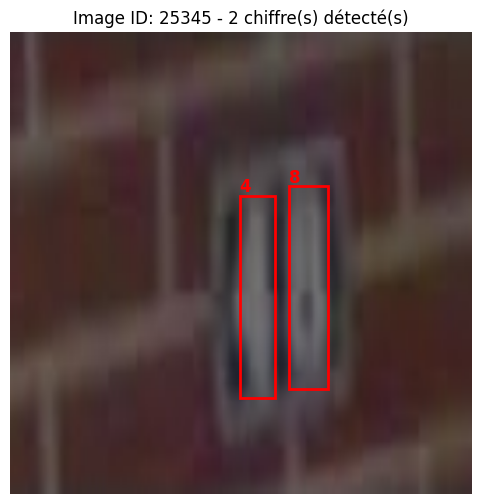

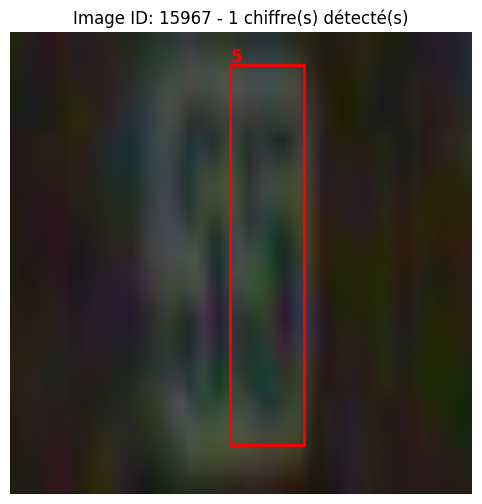

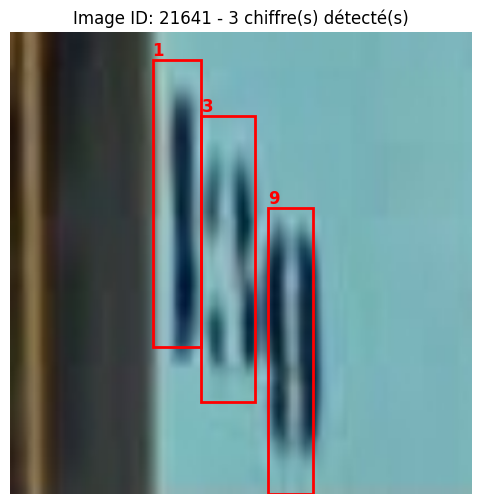

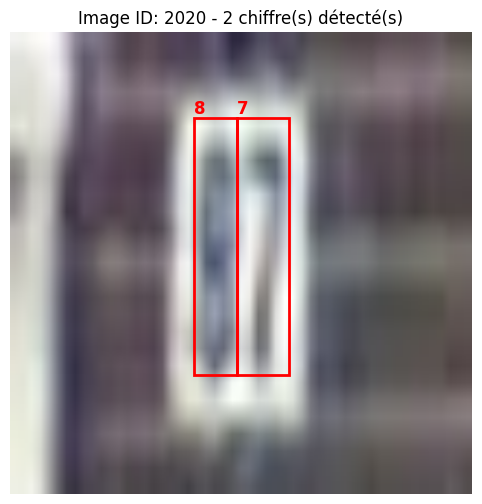

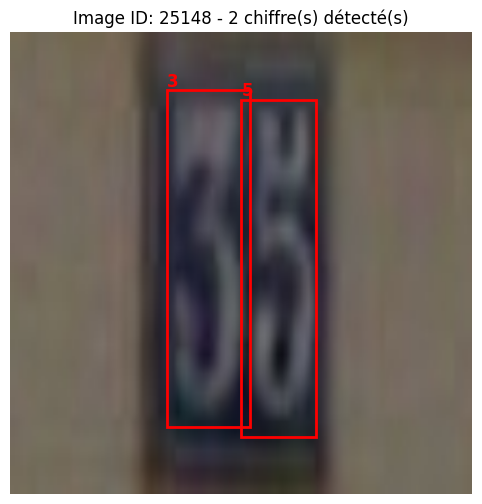

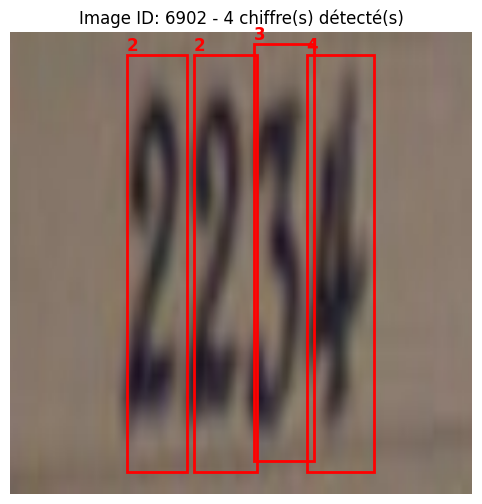

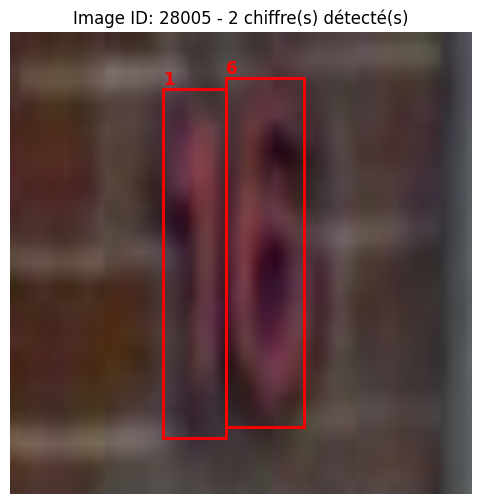

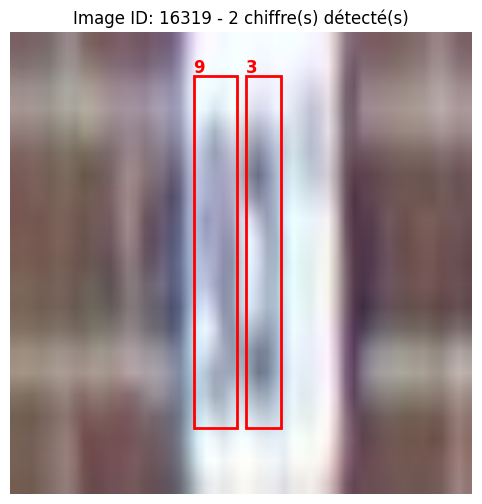

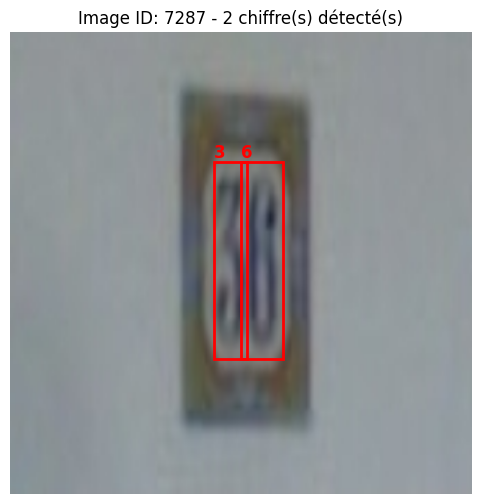

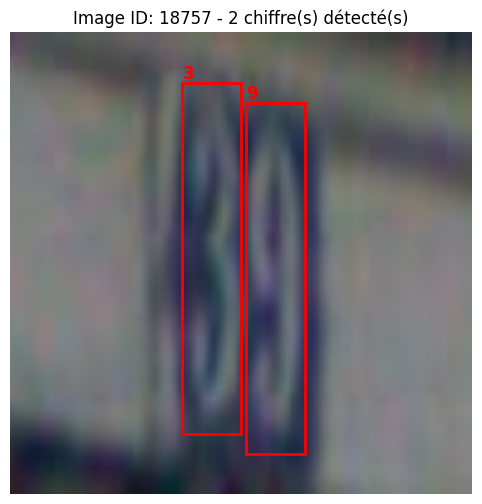

In [110]:
for _ in range(10):
    show_random_sample(train_dataset)

In [111]:
#check why there are number without bbox
img_id = 19619
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
print(f"Annotations for image {img_id} :", anns)

img_id = 5591
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
print(f"Annotations for image {img_id} :", anns)


Annotations for image 19619 : [{'id': 42957, 'image_id': 19619, 'bbox': [23.0, 5.0, 9.0, 20.0], 'category_id': 5, 'area': 180.0, 'iscrowd': 0}, {'id': 42958, 'image_id': 19619, 'bbox': [33.0, 2.0, 9.0, 20.0], 'category_id': 1, 'area': 180.0, 'iscrowd': 0}, {'id': 42959, 'image_id': 19619, 'bbox': [42.0, 5.0, 9.0, 20.0], 'category_id': 5, 'area': 180.0, 'iscrowd': 0}]
Annotations for image 5591 : [{'id': 12313, 'image_id': 5591, 'bbox': [111.0, 19.0, 30.0, 59.0], 'category_id': 3, 'area': 1770.0, 'iscrowd': 0}]


In [ ]:
#loading model

def get_model(num_classes):
    # loading pretrained model on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True);

    # Recover the number of classifier inputs
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace classifier with new one for 10 classes (0 to 9)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Number of classes = 10 digits (0-9) +1 back
model = get_model(num_classes=11)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# define params
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# define training
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(data_loader):
        # Envoyer sur GPU
        images = [img.to(device) for img in images]
        #model.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zéro gradient
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    return epoch_loss / len(data_loader)

In [ ]:
#define validation
@torch.no_grad()
def evaluate_model_on_validation(model, data_loader, device):
    model.train() #keep train to see the loss
    total_loss = 0.0

    for images, targets in tqdm(data_loader, desc="Validation"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

    return total_loss / len(data_loader)

In [ ]:
num_epochs = 10  # train

best_val_loss = float("inf")
best_model_path = "/content/drive/MyDrive/best_model.pth"
model.load_state_dict(torch.load("/content/fasterrcnn_epoch4.pth"))

os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

best_map = 0.0
avg_map = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    start = time.time()

    avg_train_loss = train_one_epoch(model, optimizer, train_loader, device)

    if epoch % 3 == 0 or epoch == num_epochs - 1:
      avg_val_loss = evaluate_model_on_validation(model, val_loader, device)
    else:
      avg_val_loss = None

    lr_scheduler.step()

    duration = time.time() - start

    print(f"Train Loss : {avg_train_loss:.4f} |", end=' ')

    if avg_val_loss is not None:
        print(f"Val Loss : {avg_val_loss:.4f} |", end=' ')
    print(f"{duration:.1f} sec")

    #Save the models
    save_dir = "/content/drive/MyDrive"
    torch.save(model.state_dict(), f"fasterrcnn_epoch{epoch+1}.pth")

    if avg_val_loss is not None and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(),best_model_path)
        print("Best model saved")


Epoch 1/4


Validation: 100%|██████████| 418/418 [02:25<00:00,  2.88it/s]


Train Loss : 0.1900 | Val Loss : 0.1638 | 2740.3 sec
Best model saved

Epoch 2/4


100%|██████████| 3758/3758 [43:19<00:00,  1.45it/s]


Train Loss : 0.1541 | 2599.5 sec

Epoch 3/4


100%|██████████| 3758/3758 [43:22<00:00,  1.44it/s]


Train Loss : 0.1484 | 2602.0 sec

Epoch 4/4


Validation: 100%|██████████| 418/418 [02:25<00:00,  2.88it/s]


Train Loss : 0.1365 | Val Loss : 0.1437 | 2747.8 sec
Best model saved


In [ ]:
#below is the next of training

In [ ]:
checkpoint_path = "/content/fasterrcnn_epoch4.pth"

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
print("Modèle chargé depuis l’époque 4 (fasterrcnn_epoch4.pth)") #loading 4th epoch

for epoch in range(5,11):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    start = time.time()

    avg_train_loss = train_one_epoch(model, optimizer, train_loader, device)

    if epoch % 3 == 0 or epoch == num_epochs - 1:
      avg_val_loss = evaluate_model_on_validation(model, val_loader, device)
    else:
      avg_val_loss = None

    lr_scheduler.step()

    duration = time.time() - start

    print(f"Train Loss : {avg_train_loss:.4f} |", end=' ')

    if avg_val_loss is not None:
        print(f"Val Loss : {avg_val_loss:.4f} |", end=' ')
    print(f"{duration:.1f} sec")

    #Save modèle
    save_dir = "/content/drive/MyDrive"
    torch.save(model.state_dict(), f"fasterrcnn_epoch{epoch+1}.pth")

    if avg_val_loss is not None and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(),best_model_path)
        print("Best model saved")

#amp

✅ Modèle chargé depuis l’époque 4 (fasterrcnn_epoch4.pth)

Epoch 6/10


100%|██████████| 3758/3758 [43:23<00:00,  1.44it/s]


Train Loss : 0.1744 | 2603.3 sec

Epoch 7/10


Validation: 100%|██████████| 418/418 [02:25<00:00,  2.87it/s]


Train Loss : 0.1517 | Val Loss : 0.1551 | 2749.1 sec
Best model saved

Epoch 8/10


100%|██████████| 3758/3758 [43:24<00:00,  1.44it/s]


Train Loss : 0.1489 | 2604.7 sec

Epoch 9/10


100%|██████████| 3758/3758 [43:23<00:00,  1.44it/s]


Train Loss : 0.1441 | 2603.7 sec

Epoch 10/10


Validation: 100%|██████████| 418/418 [02:25<00:00,  2.87it/s]


Train Loss : 0.1445 | Val Loss : 0.1545 | 2752.3 sec
Best model saved

Epoch 11/10


100%|██████████| 3758/3758 [43:24<00:00,  1.44it/s]


Train Loss : 0.1444 | 2604.2 sec


#Evaluation

In [112]:
# === loading test path ===
test_img_dir = "/content/drive/MyDrive/nycu-hw2-data/test"

# === Lister les fichiers image
image_files = sorted([f for f in os.listdir(test_img_dir) if f.endswith(".png") or f.endswith(".jpg")])

# === Tri par défaut (lexicographique)
print("Tri lexicographique par défaut (sorted):")
for idx, f in enumerate(image_files[:10]):
    print(f"image_id: {idx}, file: {f}")

# === Tri naturel (1, 2, ..., 10, 11)
image_files_natural = sorted(image_files, key=natural_key)
print("\nTri naturel (avec numéro logique):")
for idx, f in enumerate(image_files_natural[:10]):
    print(f"image_id: {idx}, file: {f}")


Tri lexicographique par défaut (sorted):
image_id: 0, file: 1.png
image_id: 1, file: 10.png
image_id: 2, file: 100.png
image_id: 3, file: 1000.png
image_id: 4, file: 10000.png
image_id: 5, file: 10001.png
image_id: 6, file: 10002.png
image_id: 7, file: 10003.png
image_id: 8, file: 10004.png
image_id: 9, file: 10005.png

Tri naturel (avec numéro logique):
image_id: 0, file: 1.png
image_id: 1, file: 2.png
image_id: 2, file: 3.png
image_id: 3, file: 4.png
image_id: 4, file: 5.png
image_id: 5, file: 6.png
image_id: 6, file: 7.png
image_id: 7, file: 8.png
image_id: 8, file: 9.png
image_id: 9, file: 10.png


In [ ]:
# === check of the order of files" (ex: 1.png, 2.png, 10.png)
def natural_key(filename):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', filename)]

In [ ]:
# === Path
test_img_dir = "/content/drive/MyDrive/nycu-hw2-data/test"
model_path = "/content/fasterrcnn_epoch10.pth"
best_model_path = "/content/drive/MyDrive/best_model.pth"

output_path = "pred valid.json"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# === Model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model


num_classes = 11

model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# === Prétraitement
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

image_files = sorted([f for f in os.listdir(test_img_dir) if f.endswith(".png")], key=natural_key)
# === Predictions
results = []
score_threshold = 0.6

with torch.no_grad():
    for filename in tqdm(image_files):
        img_id = int(os.path.splitext(filename)[0])
        img_path = os.path.join(test_img_dir, filename)

        # Original photo loading
        img = Image.open(img_path).convert("RGB")
        orig_width, orig_height = img.size

        # Resize for model
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Prediction
        output = model(img_tensor)[0]

        # Resize to original size
        scale_x = orig_width / 512
        scale_y = orig_height / 512

        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < score_threshold:
                continue

            x1, y1, x2, y2 = box.tolist()
            x1 *= scale_x
            y1 *= scale_y
            x2 *= scale_x
            y2 *= scale_y

            bbox = [min(x1, x2), min(y1, y2), abs(x2 - x1), abs(y2 - y1)]
            category_id = int(label.item()) +1

            results.append({
                "image_id": img_id,
                "category_id": category_id,
                "bbox": bbox,
                "score": float(score)
            })

# === Save
with open(output_path, "w") as f:
    json.dump(results, f)

print(f"pred.json généré avec {len(results)} prédictions")


100%|██████████| 13068/13068 [10:25<00:00, 20.89it/s]


pred.json généré avec 25395 prédictions


Check the result of eval

In [ ]:
def load_predictions(json_path):
    with open(json_path, 'r') as f:
        preds = json.load(f)
    return pd.DataFrame(preds)

def show_predictions_on_image(image_id, image_dir, pred_df, score_threshold=0.6):
    image_path = os.path.join(image_dir, f"{image_id}.png")
    if not os.path.exists(image_path):
        print(f"❌ Image introuvable : {image_path}")
        return

    image = Image.open(image_path).convert("RGB")
    preds = pred_df[(pred_df["image_id"] == image_id) & (pred_df["score"] >= score_threshold)]

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)

    for _, row in preds.iterrows():
        x, y, w, h = row["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f'{int(row["category_id"])} ({row["score"]:.2f})',
                color='white', fontsize=9, bbox=dict(facecolor='red', alpha=0.5))

        # === Bloc de debug à insérer dans ta boucle d'inférence


    plt.axis("off")
    plt.title(f"Image {image_id} – {len(preds)} prédictions")
    plt.show()


In [ ]:
# Charger le fichier pred.json
pred_df = load_predictions("/content/pred.json")  # ← adapte le chemin

# Afficher les résultats sur l'image 1.png

for i in range(200):
  show_predictions_on_image(i, "/content/drive/MyDrive/nycu-hw2-data/test", pred_df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/pred.json'

In [113]:
# when json file doesn't have the right category_id (+ or - 1)

# Charger le fichier
with open("pred.json", "r") as f:
    preds = json.load(f)

# Appliquer le +1 sur category_id
for pred in preds:
    pred["category_id"] += 1

# Sauvegarder dans un nouveau fichier
with open("pred_corrected.json", "w") as f:
    json.dump(preds, f)

print("pred_corrected.json généré avec category_id + 1")


FileNotFoundError: [Errno 2] No such file or directory: 'pred.json'

#TASK 2


In [ ]:
from collections import defaultdict

# === Params ===
input_json = "pred_corrected.json"
output_csv = "pred.csv"
score_threshold = 0.72 # minimal threshold for pred.csv

# === loading pred.json ===
with open(input_json, "r") as f:
    predictions = json.load(f)

# === Group digits by image_id, with their horizontal position (x1) ===
image_digits = defaultdict(list)

for pred in predictions:
    image_id = pred["image_id"]
    score = pred["score"]
    if score < score_threshold:
        continue

    x1 = pred["bbox"][0]
    category_id = pred["category_id"]  # 1 to 10 → numbers 0 à 9
    digit = str((category_id - 1) % 10)  # 1→0, 2→1, ..., 10→9

    image_digits[image_id].append((x1, digit))

# === Build sorted predictions (left → right) for each image ===
all_image_ids = sorted(set(pred["image_id"] for pred in predictions))
rows = []

for image_id in all_image_ids:
    digits = image_digits.get(image_id, [])
    if not digits:
        predicted_number = "-1"  # No number detected
    else:
        digits.sort()  # sorted
        predicted_number = "".join(d[1] for d in digits)

    rows.append({"image_id": image_id, "pred_label": predicted_number})

# === Export en CSV ===
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)
print(f"File '{output_csv}' generated with {len(df)} predictions.")

File 'pred.csv' generated with 12666 predictions.
